In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

Explore the viral infection efficiency data

In [2]:
inf_eff_df = pd.read_csv("output/gpp-infection-efficiencies.csv.gz")

Add gene names to the data frame

In [3]:
gene_df = (
    pd.read_csv(
        "../datasets/metadata/orf.csv.gz",
        usecols=["Metadata_broad_sample", "Metadata_Symbol", "Metadata_pert_type"],
    )
    .rename(
        columns={"Metadata_broad_sample": "broad_sample", "Metadata_Symbol": "Symbol"}
    )
    .drop_duplicates()
    .dropna(subset=["broad_sample"])
)

inf_eff_df = inf_eff_df.merge(gene_df, on="broad_sample", how="left")
inf_eff_df["Symbol"] = np.where(inf_eff_df["broad_sample"]=="EMPTY", "EMPTY", inf_eff_df["Symbol"])
inf_eff_df.head()

,Batch,Batch_name,Plate_name,Well,Row,Column,broad_sample,Plus_Blast,Minus_Blast,I.E_percentage,Minus_Avg_Background,Symbol,Metadata_pert_type
0,Batch1,2021_04_26_Batch1,OAB84.85.86.87.A,A01,A,1,ccsbBroad304_08631,2128480,2423760,0.878173,0.825173,PCDHA8,trt
1,Batch1,2021_04_26_Batch1,OAB84.85.86.87.A,A02,A,2,ccsbBroad304_06113,2049120,2168640,0.944887,0.891887,DNM2,trt
2,Batch1,2021_04_26_Batch1,OAB84.85.86.87.A,A03,A,3,ccsbBroad304_08850,1450960,2530920,0.573294,0.520294,RHBDF1,trt
3,Batch1,2021_04_26_Batch1,OAB84.85.86.87.A,A04,A,4,EMPTY,168760,2860520,0.058996,0.005996,EMPTY,NaN
4,Batch1,2021_04_26_Batch1,OAB84.85.86.87.A,A05,A,5,ccsbBroad304_13853,2453640,2475560,0.991145,0.938145,EPB41L1,trt


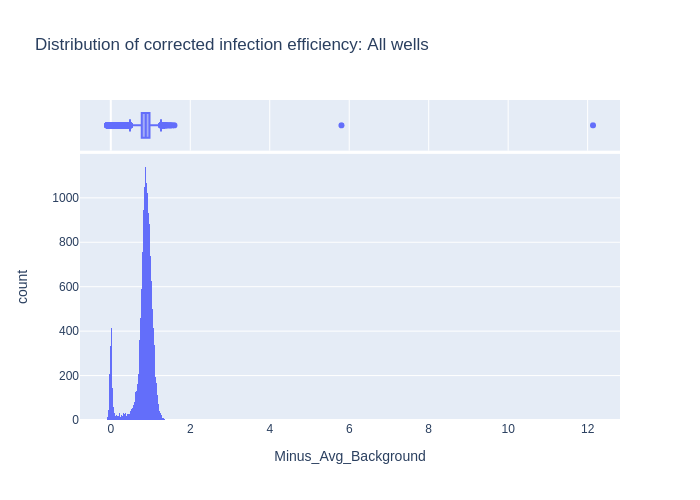

In [4]:
# Histogram of Minus_Avg_Background (i.e. corrected infection efficiency)

fig = px.histogram(
    inf_eff_df,
    x="Minus_Avg_Background",
    marginal="box",
    title="Distribution of corrected infection efficiency: All wells",
)

fig.show("png")
fig.write_image("figures/infection_efficiency_histogram_all_wells.png", width=640, height=480, scale=2)

In [5]:
# Sort by corrected infection efficiency

inf_eff_df.sort_values("Minus_Avg_Background", ascending=False).head()

,Batch,Batch_name,Plate_name,Well,Row,Column,broad_sample,Plus_Blast,Minus_Blast,I.E_percentage,Minus_Avg_Background,Symbol,Metadata_pert_type
73,Batch1,2021_04_26_Batch1,OAB84.85.86.87.A,D02,D,2,ccsbBroad304_13921,2807080,230320,12.187739,12.134739,PLXNA2,trt
8542,Batch6,2021_06_14_Batch6,OAB01.02.03.04.A,D23,D,23,ccsbBroad304_15825,1811480,310200,5.839716,5.804947,RSL24D1,trt
9500,Batch7,2021_06_21_Batch7,OAB05.06.07.08.A,L21,L,21,ccsbBroad304_06403,873760,529880,1.648977,1.601884,HSD11B1,trt
14959,Batch10,2021_08_02_Batch10,OAC01.02.03.04.A,P08,P,8,ccsbBroad304_00261,2696800,1675290,1.609751,1.556920,CD53,trt
2814,Batch2,2021_05_31_Batch2,OAA29.30.31.32.A,F07,F,7,ccsbBroad304_01753,1424120,904000,1.575354,1.512854,UCK2,trt


In [6]:
# Drop outliers

inf_eff_df = inf_eff_df.query("Minus_Avg_Background < 2")

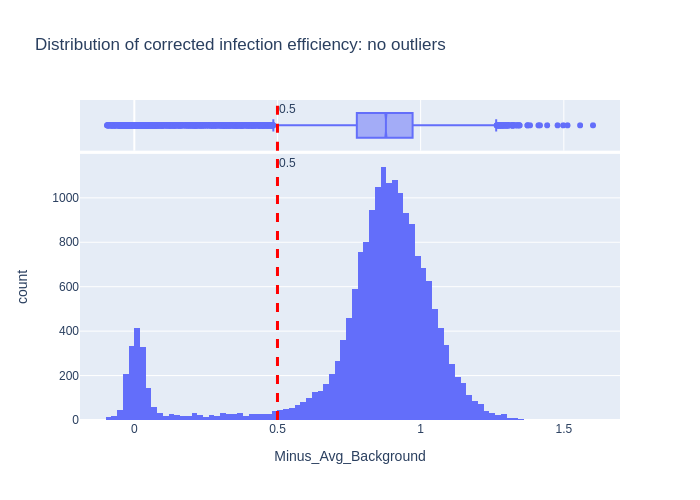

In [7]:
# Histogram of Minus_Avg_Background (i.e. corrected infection efficiency)

fig = px.histogram(
    inf_eff_df,
    x="Minus_Avg_Background",
    marginal="box",
    title="Distribution of corrected infection efficiency: no outliers",
)

# Add vertical line at 0.5

fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="red", annotation_text="0.5")

fig.show("png")
fig.write_image("figures/infection_efficiency_histogram_no_outliers.png", width=640, height=480, scale=2)

What genes have infection efficiency less than 0.5?

In [8]:
print(
    inf_eff_df.query("Minus_Avg_Background < 0.5")
    .Symbol.value_counts()
    .reset_index()
    .rename(columns={"index": "Symbol", "Symbol": "well_count"})
    .head()
    .to_markdown()
)

|    | Symbol   |   well_count |
|---:|:---------|-------------:|
|  0 | EMPTY    |          882 |
|  1 | LacZ     |           71 |
|  2 | GPX4     |            3 |
|  3 | IL9R     |            3 |
|  4 | GPRC5C   |            3 |


`EMPTY` wells have low infection efficiency. Are there `EMPTY` wells with high infection efficiency?

In [9]:
print(
    inf_eff_df.query("Minus_Avg_Background >= 0.5")
    .Symbol.value_counts()
    .reset_index()
    .rename(columns={"index": "Symbol", "Symbol": "well_count"})
    .head(6)
    .to_markdown()
)

|    | Symbol     |   well_count |
|---:|:-----------|-------------:|
|  0 | eGFP       |          418 |
|  1 | BFP        |          199 |
|  2 | HcRed      |          199 |
|  3 | LUCIFERASE |          198 |
|  4 | LacZ       |          130 |
|  5 | IGHG1      |           11 |


There aren't many `EMPTY` wells with high infection efficiency. 

Next, let's look at the distribution of infection efficiency for the controls

In [10]:
inf_eff_control_df = inf_eff_df.query("Metadata_pert_type == 'negcon' or Metadata_pert_type == 'poscon'")

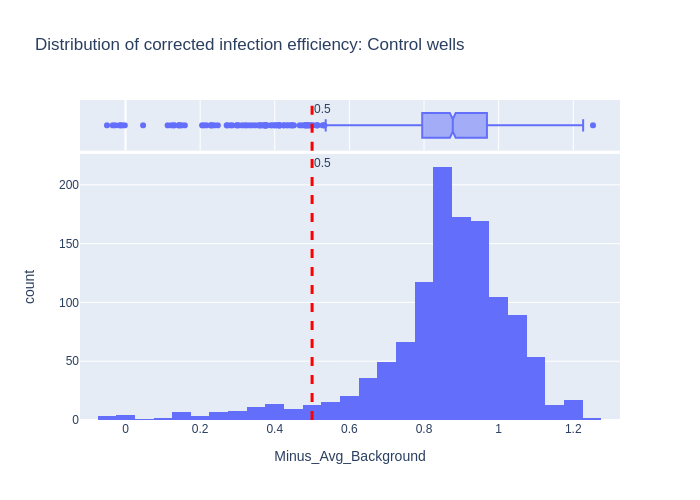

In [11]:
# Histogram of Minus_Avg_Background (i.e. corrected infection efficiency)

fig = px.histogram(
    inf_eff_control_df,
    x="Minus_Avg_Background",
    marginal="box",
    title="Distribution of corrected infection efficiency: Control wells",
)

# Add vertical line at 0.5

fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="red", annotation_text="0.5")

fig.show("png")
fig.write_image("figures/infection_efficiency_histogram_control_wells.png", width=640, height=480, scale=2)

Not many control wells with low infection efficiency. Let's look at control infection effiency >= 0.5 and < 0.5 separately.

In [12]:
print(
    inf_eff_control_df.query("Minus_Avg_Background >= 0.5")
    .Symbol.value_counts()
    .reset_index()
    .rename(columns={"index": "Symbol", "Symbol": "well_count"})
    .head()
    .to_markdown()
)

|    | Symbol     |   well_count |
|---:|:-----------|-------------:|
|  0 | eGFP       |          418 |
|  1 | HcRed      |          199 |
|  2 | BFP        |          199 |
|  3 | LUCIFERASE |          198 |
|  4 | LacZ       |          130 |


In [13]:
print(
    inf_eff_control_df.query("Minus_Avg_Background < 0.5")
    .Symbol.value_counts()
    .reset_index()
    .rename(columns={"index": "Symbol", "Symbol": "well_count"})
    .head()
    .to_markdown()
)

|    | Symbol     |   well_count |
|---:|:-----------|-------------:|
|  0 | LacZ       |           71 |
|  1 | LUCIFERASE |            3 |
|  2 | HcRed      |            2 |
|  3 | BFP        |            2 |


A third of `LacZ` wells have low infection efficiency.

Once `LacZ` and `EMPTY` wells are removed, there are still a number of genes with low infection efficiency.

In [14]:
# Removing `EMPTY` and LacZ wells.

inf_eff_df = inf_eff_df.query("Symbol != 'EMPTY' and Symbol != 'LacZ'")

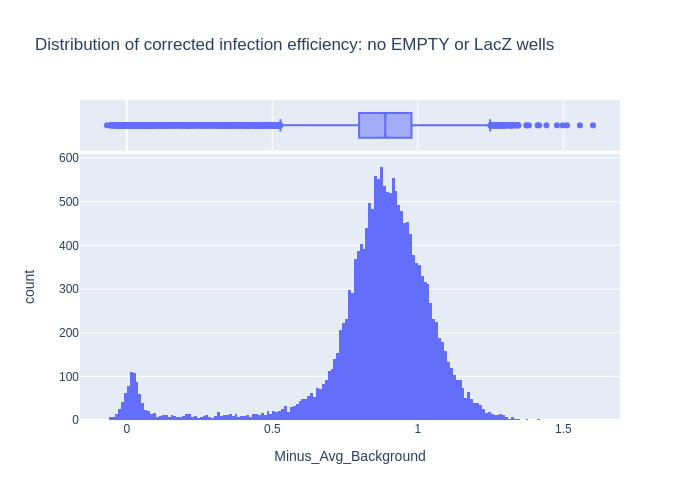

In [15]:
# Re-plot histogram

fig = px.histogram(
    inf_eff_df,
    x="Minus_Avg_Background",
    marginal="box",
    title="Distribution of corrected infection efficiency: no EMPTY or LacZ wells",
)

fig.show("png")
fig.write_image("figures/infection_efficiency_histogram_no_empty_or_lacz.png", width=640, height=480, scale=2)

In [16]:
print(pd.DataFrame(
    {
        "Threshold": ["0.5", "0.1"],
        "Number of genes below threshold": [
            inf_eff_df.query("Minus_Avg_Background < 0.5").Symbol.nunique(),
            inf_eff_df.query("Minus_Avg_Background < 0.1").Symbol.nunique(),
        ],
        "Number of reagents below threshold": [
            inf_eff_df.query("Minus_Avg_Background < 0.5").broad_sample.nunique(),
            inf_eff_df.query("Minus_Avg_Background < 0.1").broad_sample.nunique(),
        ],
    }
)
.to_markdown(index=False)
)

|   Threshold |   Number of genes below threshold |   Number of reagents below threshold |
|------------:|----------------------------------:|-------------------------------------:|
|         0.5 |                              1062 |                                 1080 |
|         0.1 |                               677 |                                  681 |
